## Training your first Convolutional Neural Network with Keras

In [1]:
# A simple feedforward neural network to classify images can be improved by leveraging 
# on Convolutional Neural Networks (CNNs) which are designed to operate over the raw pixel intensities of images 
# and learn discriminating filters that can be used to classify images with high accuracy

# VGGNet-like models share two common characteristics:
# * Only 3×3 convolutions are used
# * Convolution layers are stacked on top of each other deeper in the network architecture prior to applying a destructive pooling operation

# The model we’ll be discussing here today is a smaller variant of VGGNet which I have named “SmallVGGNet”.

### to implement SmallVGGNet

In [2]:
# smallvggnet.py

# import the necessary packages
import keras
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K

# define our SmallVGGNet class and the build method
# Should I use "ELU" for hidden layer as better for image classification?
class SmallVGGNet:
    @staticmethod
    def build(width, height, depth, classes):
        # initialize the model along with the input shape to be "channels last" and the channels dimension/depth itself
        model = Sequential()   # (i.e. TensorFlow ordering)
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape and channels dimension
        if K.image_data_format() == "channels_first":   # (i.e. Theano ordering)
            inputShape = (depth, height, width)
            chanDim = 1

        # CONV => RELU => POOL layer set              # first CONV layer has 32 filters of size 3x3
        model.add(Conv2D(32, (3, 3), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))                 # ReLU (Rectified Linear Unit) activation function
        model.add(BatchNormalization(axis=chanDim))   # normalize activations of input volume before passing to next layer
        model.add(MaxPooling2D(pool_size=(2, 2)))     # progressively reduce spatial size (width and height) of input 
        model.add(Dropout(0.25))                      # disconnecting random neurons between layers, reduce overfitting

        # (CONV => RELU) * 2 => POOL layer set          # filter dimensions remain the same (3x3)
        model.add(Conv2D(64, (3, 3), padding="same"))   # increase total number of filters learned (from 32 to 64)
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(64, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # (CONV => RELU) * 3 => POOL layer set
        model.add(Conv2D(128, (3, 3), padding="same"))   # total number of filters learned by CONV layers has doubled (128)
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(Conv2D(128, (3, 3), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(Dropout(0.25))

        # first (and only) set of fully connected layer (FC) => RELU layers
        model.add(Flatten())
        model.add(Dense(512))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        # return the constructed network architecture
        return model

In [3]:
# Now that SmallVGGNet is implemented, let’s write the driver script that will be used to train it on our Animals dataset

In [10]:
# import the necessary packages
# from pyimagesearch.smallvggnet import SmallVGGNet   # "smallvggnet.py" file is in "pyimagesearch" folder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from imutils import paths
import matplotlib as plt
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import pickle
import cv2
import os
import warnings
warnings.filterwarnings("ignore")

In [11]:
# initialize the data and labels
print("[INFO] loading images...")
images = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images('animals')))
random.seed(42)
random.shuffle(imagePaths)

# loop over the input images
for imagePath in imagePaths:
    # load the image, resize it to 64x64 pixels (the required input spatial dimensions of SmallVGGNet), 
    # and store the image in the data list
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64, 64))   # we are not flattening our data for neural network, because it is convolutional
    images.append(image)

    # extract the class label from the image path and update the labels list
    label = imagePath.split(os.path.sep)[-2]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
images = np.array(images, dtype="float") / 255.0
labels = np.array(labels)

print('done')

[INFO] loading images...
done


In [12]:
# partition the data into 75% training and 25% validation, try 80/20 later
(trainX, testX, trainY, testY) = train_test_split(images,labels, test_size=0.2, random_state=42)

# before transformation
trainY

array(['Cat', 'Cat', 'Cat', ..., 'Dog', 'Cat', 'Panda'], dtype='<U5')

In [13]:
# convert the labels from integers to vectors 
# (for 2-class, binary classification you should use Keras' to_categorical function)
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# after transformation
trainY

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]])

In [27]:
# Construct & initialize the image data generator for data augmentation
# Image augmentation allows us to construct “additional” training data from our existing training data 
# by randomly rotating, shifting, shearing, zooming, and flipping. This is to avoid overfitting.
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                         height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                         horizontal_flip=True, fill_mode="nearest")

# initialize our VGG-like Convolutional Neural Network
model = SmallVGGNet.build(width=64, height=64, depth=3, classes=len(lb.classes_))

# compile & train model
# initialize our initial learning rate, # of epochs to train for, and batch size
INIT_LR = 0.01
EPOCHS = 75
BS = 32

# initialize the model and optimizer (you'll want to use binary_crossentropy for 2-class classification)
print("[INFO] training network...")
opt = SGD(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the network
H = model.fit_generator( aug.flow(trainX, trainY, batch_size=BS),
                        validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS, epochs=EPOCHS,
                        callbacks=[keras.callbacks.EarlyStopping(patience=11, verbose=1, restore_best_weights=True),
                                   keras.callbacks.ReduceLROnPlateau(factor=.5, patience=4, verbose=1)] )

[INFO] training network...
Epoch 1/75
75/75 [==============================] - 83s 1s/step - loss: 1.3729 - acc: 0.5225 - val_loss: 1.5503 - val_acc: 0.5817
Epoch 2/75
75/75 [==============================] - 77s 1s/step - loss: 1.0293 - acc: 0.5967 - val_loss: 0.8491 - val_acc: 0.6500
Epoch 3/75
75/75 [==============================] - 78s 1s/step - loss: 0.8895 - acc: 0.6058 - val_loss: 0.8487 - val_acc: 0.6283
Epoch 4/75
75/75 [==============================] - 78s 1s/step - loss: 0.8154 - acc: 0.6296 - val_loss: 0.8869 - val_acc: 0.5917
Epoch 5/75
75/75 [==============================] - 77s 1s/step - loss: 0.7457 - acc: 0.6533 - val_loss: 0.6590 - val_acc: 0.6733
Epoch 6/75
75/75 [==============================] - 77s 1s/step - loss: 0.7332 - acc: 0.6483 - val_loss: 0.6759 - val_acc: 0.6750
Epoch 7/75
75/75 [==============================] - 77s 1s/step - loss: 0.7180 - acc: 0.6579 - val_loss: 0.9883 - val_acc: 0.6000
Epoch 8/75
75/75 [==============================] - 77s 1s/step

In [2]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))

[INFO] evaluating network...


NameError: name 'testX' is not defined

In [23]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testY, predictions))

# # Print confusion matrix heatmap for SmallVGGNet_CNN_model
# knn_confusion = confusion_matrix(testY, predictions)
# plt.figure(dpi=150)
# sns.heatmap(knn_confusion, cmap=plt.cm.Blues, annot=True, square=True,
#            xticklabels=['Cat', 'Dog', 'Panda'],
#            yticklabels=['Cat', 'Dog', 'Panda'] )
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('SmallVGGNet_CNN confusion matrix');

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets

In [ ]:
# visualize confusion matrix
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('Actual label', weight='bold')
plt.xlabel('Predicted label', weight='bold')

thresh = cm.max() / 2.

for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

tick_marks = np.arange(len(iris.target_names))
plt.xticks(tick_marks, iris.target_names, rotation=0)
plt.yticks(tick_marks, iris.target_names)

plt.show()

In [30]:
# for early stopping, change this value to the Epoch number stopped
# EPOCHS = 36

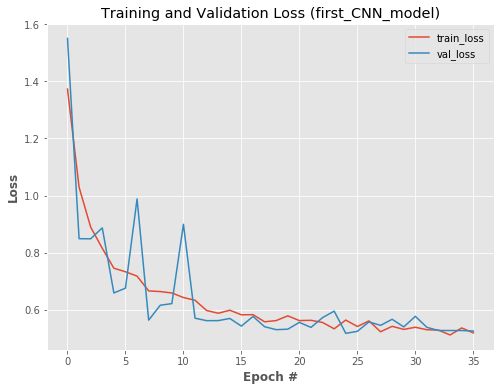

In [41]:
# plot the training/validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training and Validation Loss (first_CNN_model)")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Loss", weight='bold')
plt.legend()

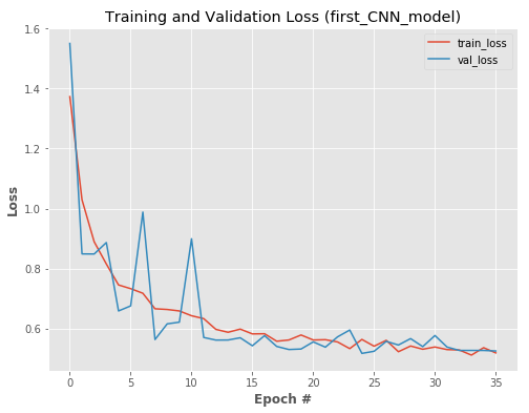

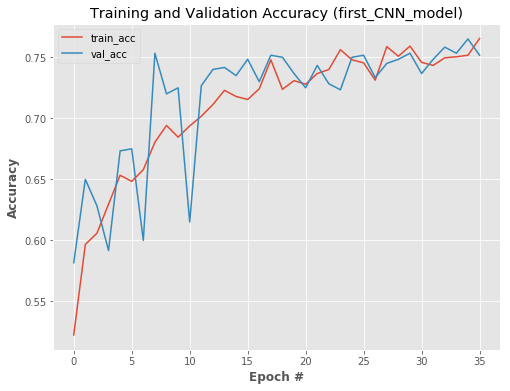

In [42]:
# plot the training/validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [8,6])
plt.plot(N, H.history["acc"], label="train_acc")
plt.plot(N, H.history["val_acc"], label="val_acc")
plt.title("Training and Validation Accuracy (first_CNN_model)")
plt.xlabel("Epoch #", weight='bold')
plt.ylabel("Accuracy", weight='bold')
plt.legend()

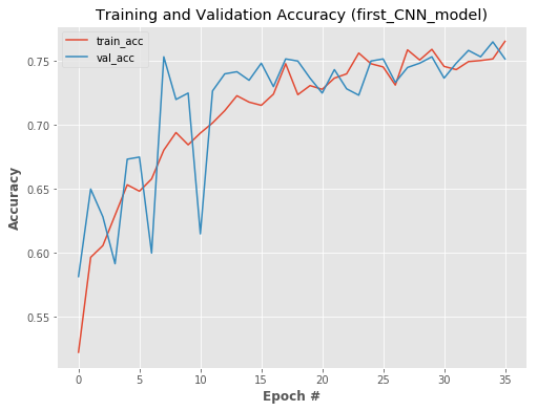

In [30]:
# As our results demonstrate, you can see that we are achieving 76% accuracy on our Animals dataset 
# using a Convolutional Neural Network, significantly higher than the previous accuracy of 61% using a 
# standard fully-connected network.

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_25 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 64, 64, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
activation_26 (Activation)   (None, 32, 32, 64)       

In [35]:
# save the model and label binarizer to disk
print("[INFO] serializing network and label binarizer...")
model.save("first_CNN_model")
f = open("first_CNN_model_label_bin", "wb")
f.write(pickle.dumps(lb))
f.close()

[INFO] serializing network and label binarizer...


In [9]:
# make prediction

# import the necessary packages
from keras.models import load_model
# import argparse
import pickle
import cv2

# load the input image and resize it to the target spatial dimensions
width = 64
height = 64
image = cv2.imread("images\dog_difficult3.jpg")
output = image.copy()
image = cv2.resize(image, (width, height))

# scale the pixel values to [0, 1]
image = image.astype("float") / 255.0

# when working with a CNN: don't flatten the image, simply add the batch dimension
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

# # load the model and label binarizer
# print("[INFO] loading network and label binarizer...")
# model = load_model('first_CNN_model')
# lb = pickle.loads(open("first_CNN_model_label_bin", "rb").read())

# make a prediction on the image
preds = model.predict(image)

# find the class label index with the largest corresponding probability
i = preds.argmax(axis=1)[0]
label = lb.classes_[i]

# draw the class label + probability on the output image
text = "{}: {:.1f}%".format(label, preds[0][i] * 100)
cv2.putText(output, text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)

# show the output image
cv2.imshow("Image", output)
cv2.waitKey(0)   # Delay in milliseconds. 0 is the special value that means “forever”, until you close the image window

-1

Text(0, 0.5, 'Category')

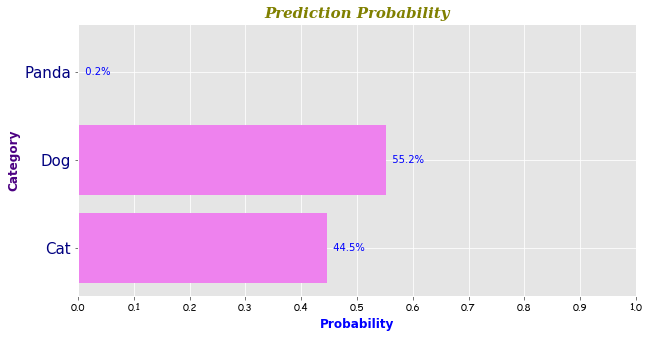

In [8]:
# plot the prediction probability for each category
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("ggplot")
plt.figure(figsize = [10,5])   # [width, height]

x = [ lb.classes_[0], lb.classes_[1], lb.classes_[2] ]
y = [ preds[0][0], preds[0][1], preds[0][2] ]
plt.barh(x, y, color='violet')

ticks_x = np.linspace(0, 1, 11)   # (start, end, number of ticks)
plt.xticks(ticks_x, fontsize=10, family='fantasy', color='black')
plt.yticks( size=15, color='navy' )
for i, v in enumerate(y):
    plt.text(v, i, "  "+str((v*100).round(1))+"%", color='blue', va='center', fontweight=None)

plt.title('Prediction Probability', family='serif', fontsize=15, style='italic', weight='bold', color='olive', loc='center', rotation=0)
plt.xlabel('Probability', fontsize=12, weight='bold', color='blue')
plt.ylabel('Category', fontsize=12, weight='bold', color='indigo')

In [ ]:
#               precision    recall  f1-score   support

#          Cat       0.67      0.73      0.70       189
#          Dog       0.69      0.64      0.66       193
#        Panda       0.92      0.90      0.91       218

#    micro avg       0.76      0.76      0.76       600
#    macro avg       0.76      0.76      0.76       600
# weighted avg       0.77      0.76      0.76       600

In [ ]:
#               precision    recall  f1-score   support

#          Cat       0.63      0.80      0.71       189
#          Dog       0.71      0.52      0.60       193
#        Panda       0.90      0.91      0.91       218

#    micro avg       0.75      0.75      0.75       600
#    macro avg       0.75      0.74      0.74       600
# weighted avg       0.76      0.75      0.74       600

Correct prediction!
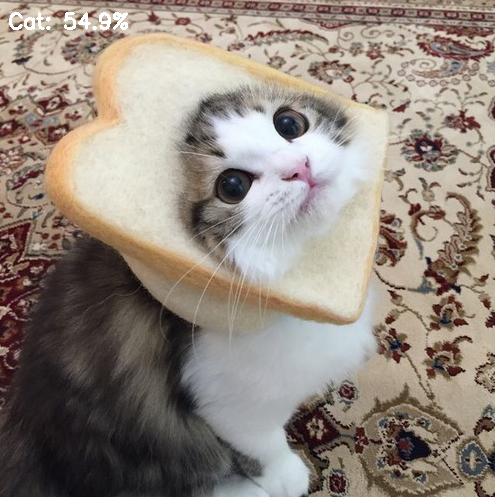

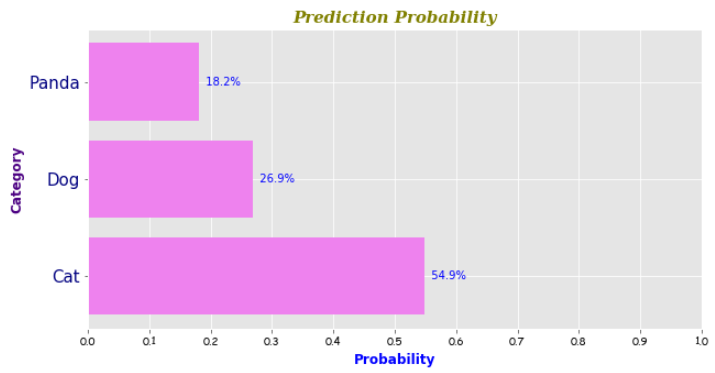

Correct prediction!
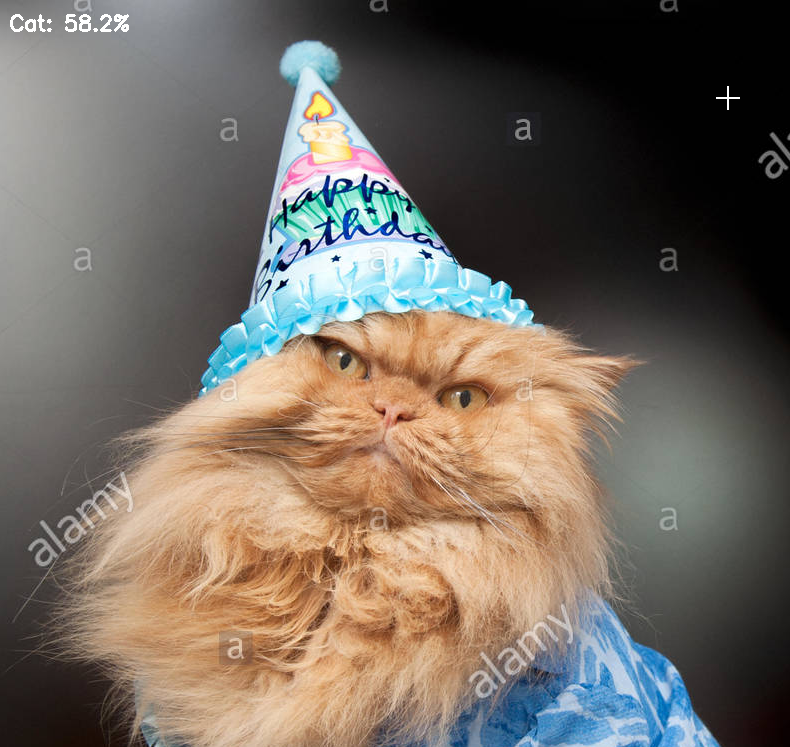

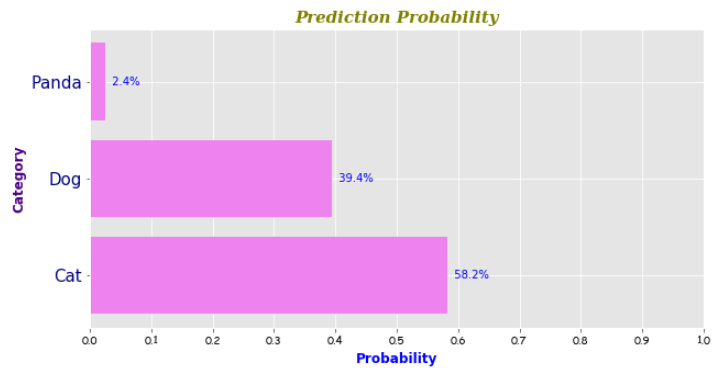

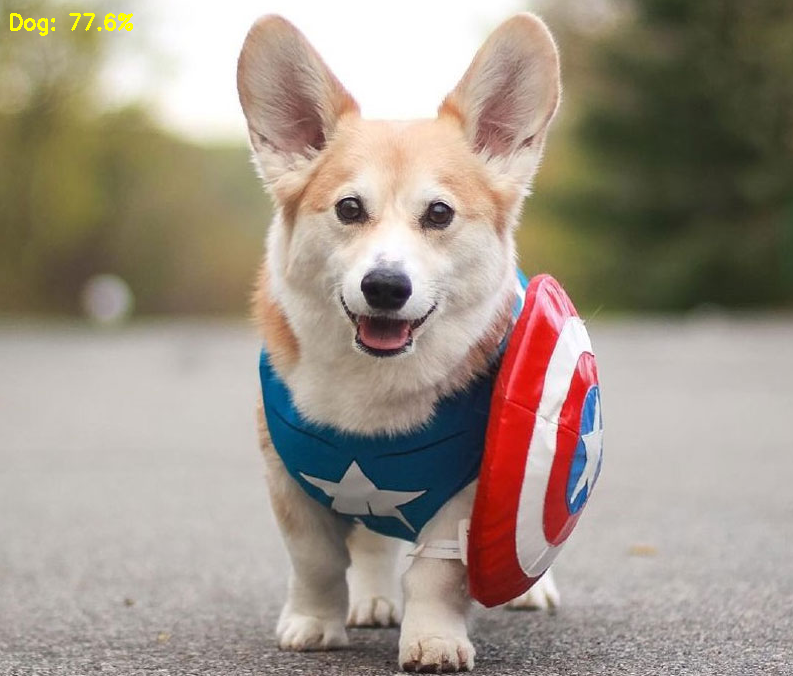

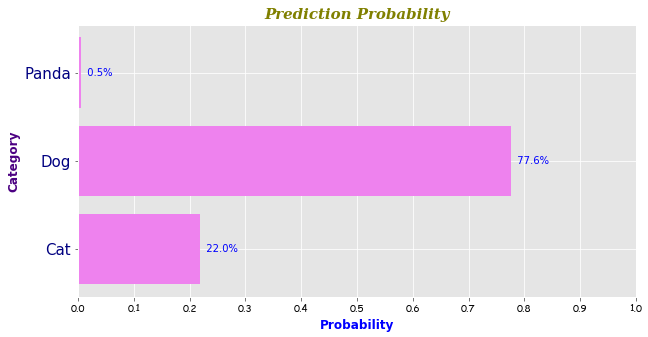

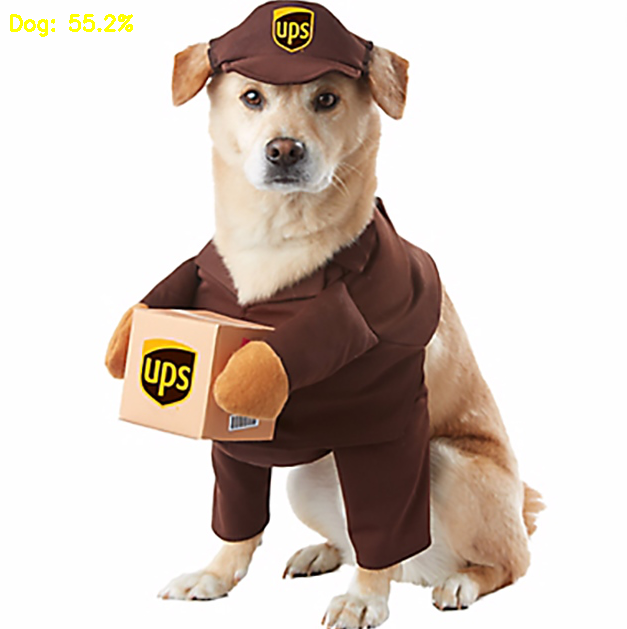

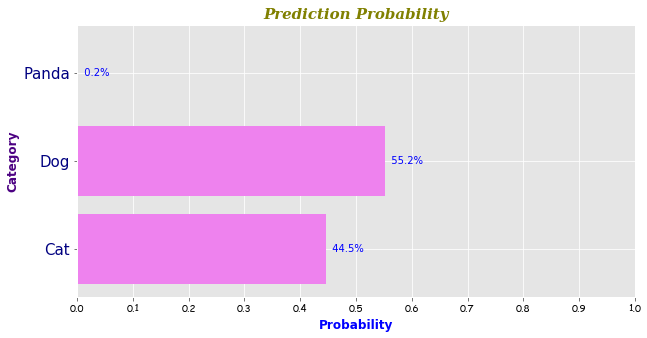

# Conclusion:
Convolutional Neural Network is able to obtain higher accuracy than a standard fully-connected network